In [1]:
import keras
import tensorflow as tf

import os
tf.config.optimizer.set_jit(False)  # Desativa XLA

2024-09-19 14:37:13.513812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 14:37:13.527598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 14:37:13.531587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 14:37:13.541167: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 14:37:14.461910: W tensorflow/compiler/tf2

In [2]:
from segmentandoDatasets import *

segmentando_datasets(10000,10000,10000)

DataFrame do local PUC salvo como: Datasets_csv/df_PUC.csv
DataFrame do local PUC:
                                      caminho_imagem    classe
0  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
1  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
2  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
3  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied
4  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied


DataFrame do local UFPR04 salvo como: Datasets_csv/df_UFPR04.csv
DataFrame do local UFPR04:
                                      caminho_imagem    classe
0  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
1  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
2  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
3  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...  Occupied
4  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty


DataFrame do local UFPR05 salvo como: Datasets_csv/df_UFPR05.csv


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from typing import List, Tuple
import os

def preprocessamento(caminho: str, proporcao_treino: float = 0.6, proporcao_teste: float = 0.2, proporcao_validacao: float = 0.2, autoencoder: bool = False):
    """
    Ao passar um dataFrame .csv, ele irá retornar geradores de dados para treino, teste e validação + os 3 .csv dividos igualmente os geradores.
    
    Parâmetros:
        caminho (str): Caminho para o arquivo CSV.
        proporcao_treino (float): Proporção de dados de treino.
        proporcao_teste (float): Proporção de dados de teste.
        proporcao_validacao (float): Proporção de dados de validação.
        autoencoder (bool): Se True, prepara os dados para um autoencoder (class_mode='input').
                            Se False, prepara os dados para classificação binária (class_mode='binary').
    
    Retorna:
        treino_gerador, validacao_gerador, teste_gerador, treino, validacao, teste
    """
    dataframe = pd.read_csv(caminho)

    treino, teste = train_test_split(dataframe, test_size=proporcao_teste, random_state=42)
    treino, validacao = train_test_split(treino, test_size=proporcao_validacao / (1 - proporcao_teste), random_state=42)

    img_width, img_height = 64, 64
    batch_size = 32

    def normalize_image(img):
        return img / 255.0

    treino_datagen = ImageDataGenerator(preprocessing_function=normalize_image)
    validacao_datagen = ImageDataGenerator(preprocessing_function=normalize_image)
    teste_datagen = ImageDataGenerator(preprocessing_function=normalize_image)

    class_mode = 'input' if autoencoder else 'binary'

    treino_gerador = treino_datagen.flow_from_dataframe(
        dataframe=treino,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe', #Usar a imagem como saída se for autoencoder
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode,  #Class mode baseado no parâmetro autoencoder
        shuffle=False
    )

    validacao_gerador = validacao_datagen.flow_from_dataframe(
        dataframe=validacao,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe',  
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode, 
        shuffle=False
    )

    teste_gerador = teste_datagen.flow_from_dataframe(
        dataframe=teste,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe',  
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode, 
        shuffle=False
    )

    return treino_gerador, validacao_gerador, teste_gerador, treino, validacao, teste

def preprocessamento_dataframe(caminho_csv: str, autoencoder: bool = False):
    dataframe = pd.read_csv(caminho_csv)

    img_width, img_height = 64, 64
    batch_size = 32

    def normalize_image(img):
            return img / 255.0

    datagen = ImageDataGenerator(preprocessing_function=normalize_image)

    class_mode = 'input' if autoencoder else 'binary'

    Dataframe_preprocessado = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=True
    )

    return Dataframe_preprocessado, dataframe

In [4]:
csv_file = 'Datasets_csv/df_PUC.csv'
treino_gerador, validacao_gerador, teste_gerador, treino, validacao, teste = preprocessamento(csv_file, autoencoder=False)

Found 6000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [5]:
from keras.layers import Input, Flatten, Dense, Reshape
from keras.models import Sequential

encoder = keras.models.Sequential([
    keras.layers.Reshape([64,64,3], input_shape=[64,64,3]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),  
], name='encoder')

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1726767436.834474  177897 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726767436.875696  177897 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726767436.875848  177897 cuda_executor.cc:1015] successful NUMA node rea

In [6]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu", input_shape=[4, 4, 128]),
    keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(3, kernel_size=(3, 3), padding="same", activation="sigmoid"),
], name='decoder')

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer='adam')

In [8]:
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 4, 4, 128)      │        97,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 64, 64, 3)      │       244,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,339 (1.31 MB)

 Trainable params: 342,339 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#history = autoencoder.fit(treino_gerador, epochs=30, batch_size=16, validation_data=(validacao_gerador))

In [10]:
#pd.DataFrame(history.history).plot()
#autoencoder.save("Modelos_keras/Autoencoder_teste.keras")
#autoencoder.save_weights("weights_finais/Autoencoder_teste.weights.h5")

In [11]:
autoencoder.load_weights("weights_finais/Autoencoder.weights.h5")

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
print(len(treino_gerador))

188


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_autoencoder(x_test, Autoencoder):
    def normalize(image):
        image = np.clip(image, 0, 1)  
        return (image - image.min()) / (image.max() - image.min()) if image.max() != image.min() else image

    plt.figure(figsize=(16, 8))

    for i in range(8):
        # Imagem original
        plt.subplot(2, 8, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis("off")

        # Predição e normalização
        pred = Autoencoder.predict(x_test[i].reshape((1, 64, 64, 3)))
        pred_img = normalize(pred[0])

        plt.subplot(2, 8, i + 8 + 1)
        plt.imshow(pred_img)
        plt.title("Reconstruída")
        plt.axis("off")

    plt.show()


In [14]:
x_treino, y_treino = next(treino_gerador)

In [15]:
UFPR04, UFPR04_df = preprocessamento_dataframe('Datasets_csv/df_UFPR04.csv')
UFPR05, UFPR05_df = preprocessamento_dataframe('Datasets_csv/df_UFPR05.csv')

x_UFPR04, _ = next(UFPR04)
x_UFPR05, _ = next(UFPR05)

Found 10000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


I0000 00:00:1726767438.179668  177962 service.cc:146] XLA service 0x79441c003a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726767438.179690  177962 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2024-09-19 14:37:18.188842: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-19 14:37:18.237828: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


I0000 00:00:1726767439.056078  177962 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


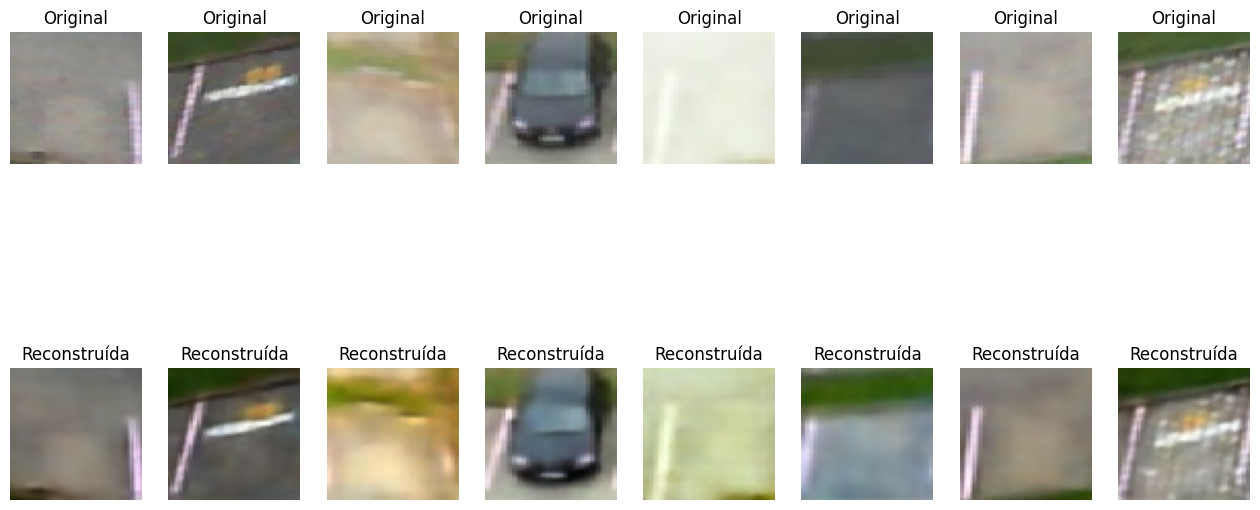

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


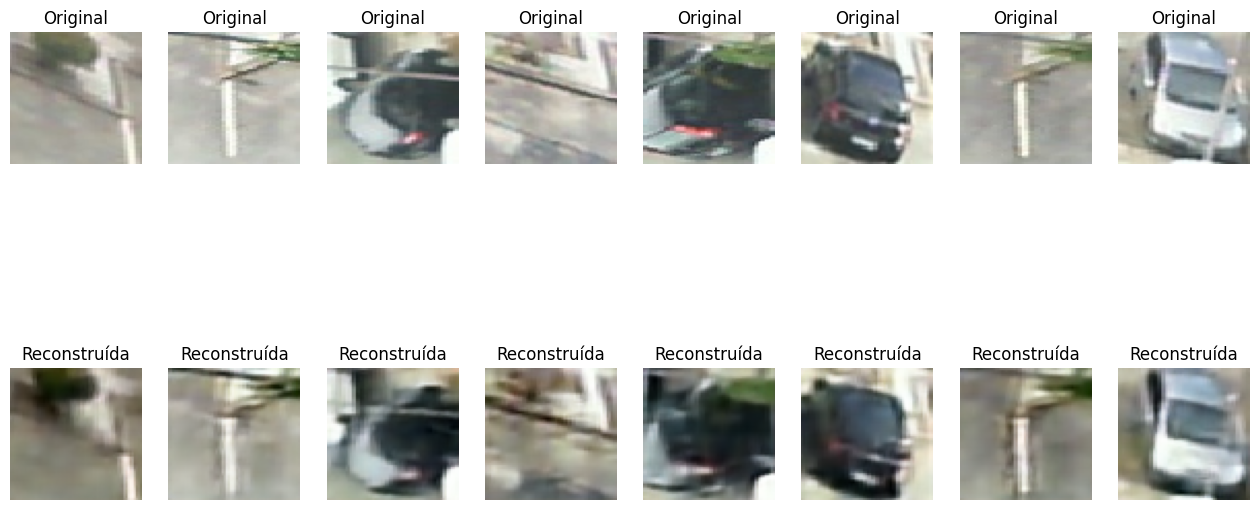

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


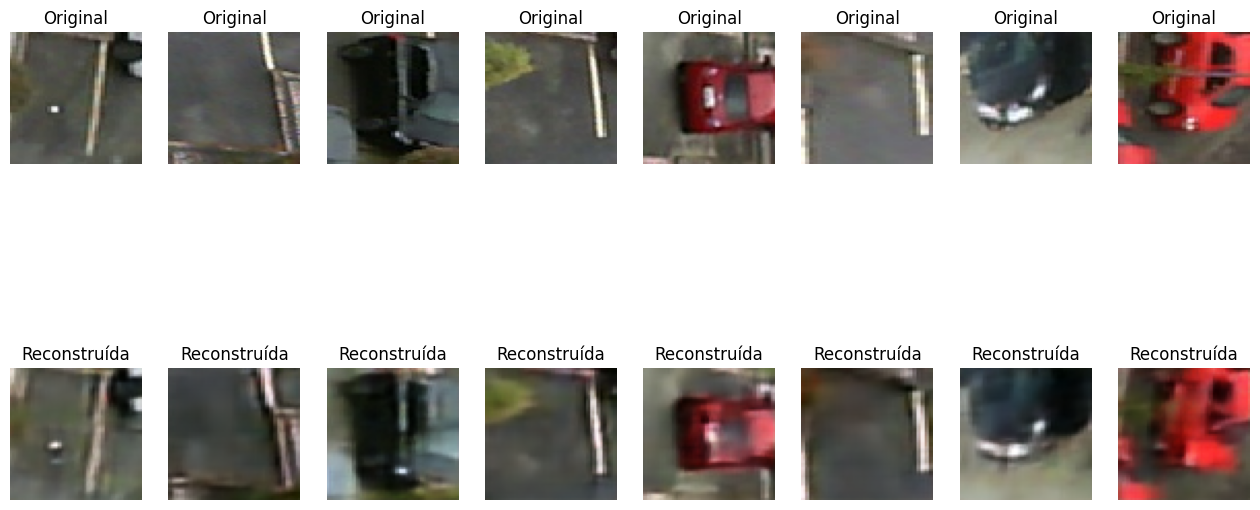

In [16]:
plot_autoencoder(x_treino, autoencoder)
plot_autoencoder(x_UFPR04, autoencoder)
plot_autoencoder(x_UFPR05, autoencoder)

In [17]:
from keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

classifier = models.Sequential([
    encoder, 
    layers.Flatten(),  
    layers.Dropout(0.3),  
    layers.Dense(128, activation='relu'),  
    layers.Dense(2, activation='softmax')  
], name='classifier')

In [18]:
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
classifier.load_weights("/home/lucas/PIBIC (copy)/weights_finais/Autoencoder.weights.h5", skip_mismatch=True) #skip_mismatch para conseguir pegar os pesos do autoencoder

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:591: UserWarning: A total of 2 objects could not be loaded. Example error message for object <Dense name=dense, built=True>:

Layer 'dense' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=dense, built=True>, <Dense name=dense_1, built=True>]
  warnings.warn(msg)


In [20]:
#history = classifier.fit(treino_gerador, epochs=10, batch_size=16, validation_data=validacao_gerador)

In [21]:
#classifier.save("/home/lucas/PIBIC (copy)/Modelos_keras/classifier.keras")
#classifier.save_weights("/home/lucas/PIBIC (copy)/Modelos_keras/classifier.weights.h5")

In [22]:
#pd.DataFrame(history.history).plot()

In [23]:
classifier.load_weights("/home/lucas/PIBIC (copy)/Modelos_keras/classifier.weights.h5")

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
predicoes = classifier.predict(teste_gerador)
predicoes = np.argmax(predicoes, axis=1)

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step


In [25]:
from preprocessamento import mapear_rotulos_binarios

y_verdadeiro = mapear_rotulos_binarios(teste['classe'])

In [26]:
from visualizacao import plot_confusion_matrix

plot_confusion_matrix(y_verdadeiro, predicoes, ['Empty', 'Occupied'], "/home/lucas/PIBIC (copy)/Resultados/Matriz_de_confusao/Autoencoder/Autoencoder_PUC", 'PUC')

In [28]:
predicoes_UFPR04 = classifier.predict(UFPR04)
predicoes_UFPR05 = classifier.predict(UFPR05)

predicoes_UFPR04 = np.argmax(predicoes_UFPR04, axis=1)
predicoes_UFPR05 = np.argmax(predicoes_UFPR05, axis=1)

y_UFPR04 = mapear_rotulos_binarios(UFPR04_df['classe'])
y_UFPR05 = mapear_rotulos_binarios(UFPR05_df['classe'])

plot_confusion_matrix(y_UFPR04, predicoes_UFPR04, ['Empty', 'Occupied'], "/home/lucas/PIBIC (copy)/Resultados/Matriz_de_confusao/Autoencoder/Autoencoder_UFPR04", 'UFPR04')
plot_confusion_matrix(y_UFPR05, predicoes_UFPR05, ['Empty', 'Occupied'], "/home/lucas/PIBIC (copy)/Resultados/Matriz_de_confusao/Autoencoder/Autoencoder_UFPR05", 'UFPR05')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
